In [4]:
from presto_mod.pulsed import pulse_test as pt
from presto_mod.pulsed import pulsed_test_with_probe as ptpr
import matplotlib.patches as patches
import time
import numpy as np
import scipy.io as sio

from scipy.io import savemat
from scipy.io import loadmat

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import time
import pyvisa

import os
Global_data_adress = r"D:\Data\2025\SNAILJPA\DTWPAMJPARR_January\Data"
exp_name = 'PulsedShortVacuum'
file_folder = Global_data_adress+'\\'+exp_name
if not os.path.exists(file_folder):
  os.mkdir(file_folder)
  print("Folder %s created!" % file_folder)
else:
  print("Folder %s already exists" % file_folder)

Folder D:\Data\2025\SNAILJPA\DTWPAMJPARR_January\Data\PulsedShortVacuum created!


In [5]:
presto_address = "169.254.3.14"  # your Presto IP address

# Test of pulse shape

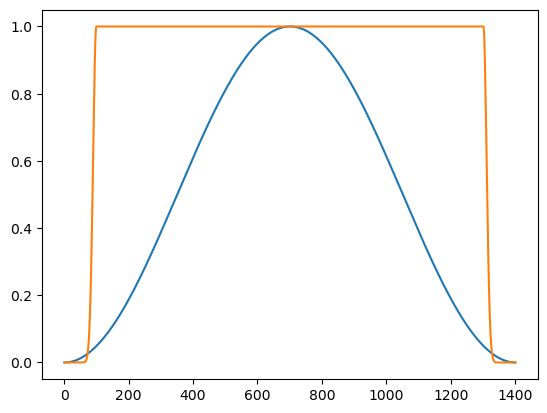

In [7]:
nr_samples = 1400
edge = 10
t = np.linspace(1,nr_samples,nr_samples)

def gate(t, start, stop):
    return np.heaviside(t-start, 1) - np.heaviside(t-stop, 1)

def gaussian(t, cent, sig, start, end):
    Result = np.zeros(int(t[-1]))
    Result[start:end] = np.exp(-np.power((t[start:end] - cent) / sig, 2.0) / 2)
    return Result
    
# def sin2(nr_of_samples, start=0, stop=9, sig_feft=2, sig_right=0.001): 
#     t = np.linspace(0, 10, number_of_samples)
#     return gate(t, start, stop) + gaussian(t, cent=start, sig=sig_feft)*(1-np.heaviside(t-start, 1)) + gaussian(t, cent=stop, sig=sig_right)*(np.heaviside(t-stop, 1))

def Gauss(nr_samples,drag,edge=100,sig_left=10,sig_right=10):
    t = np.linspace(1, nr_samples, nr_samples, endpoint=True)
    Left = gaussian(t, edge, sig_left, 0, edge)
    Middle = gate(t, edge+1, t[-edge])
    Right = gaussian(t, int(t[-edge]), sig_right,int(t[-edge-1]),int(t[-1]))
    return Left + Middle + Right

def sin2(nr_samples: int, drag: float = 0.0) -> np.ndarray:
    x = np.linspace(0.0, 1.0, nr_samples, endpoint=False)
    return np.sin(np.pi * x) ** 2

plt.plot(t, sin2(nr_samples))
plt.plot(t, Gauss(nr_samples,0))
# print(Gauss(nr_samples,edge,1,1))
# print(nr_samples)

In [8]:
print(datetime.now())

omega2 = 5.768314e9*2
lo_freq = (omega2 - 0.436e9)/2
if_freq  = omega2-lo_freq
Readout_freq = 5.768314e9
print(lo_freq)
print(if_freq)
print(Readout_freq)

delay = 200e-9
LO_duration=2000e-9
IF_duration=1400e-9
PR_duration = 2000e-9
Readout_duration = delay*4+PR_duration

experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'Pulse_test_pulse_duration',
        
        LO_freq=lo_freq,
        LO_amp=0.0/np.sqrt(2),
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = 0.0/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = 0.1,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=50e-6,
        readout_delay=200e-9,
        num_repeats=1, 
        num_averages=100000,
        envelope_function = Gauss, 
    
    )

2025-01-17 08:42:48.481933
5550314000.0
5986314000.0
5768314000.0


TypeError: T1.__init__() missing 1 required positional argument: 'readout_phase'

In [5]:
att_list = experiment.run(presto_address)

Measurement sequence processed in 996.8us3966
Expected measurement time: 5.3s
Configuring ADCs and DACs: 3.0ms
Uploading measurement parameters: 102.2ms
Measurement completed in: 5.5s
Finishing internal data transfers: 104.6ms
Total time: 5.9s
Run finished


In [64]:
data_single_sweep = att_list['data'][0]
data_single_sweep.shape

(2, 2800)

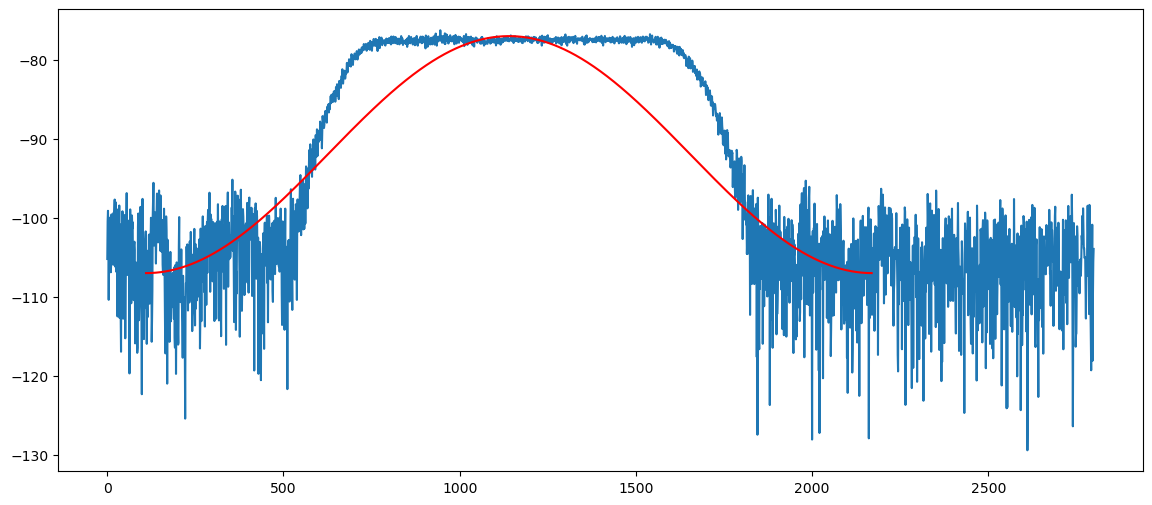

In [65]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(20*np.log10(np.abs(data_single_sweep[1])))
# ax.plot(20*np.log10(np.abs(data_single_sweep[0])))
plt.plot(np.arange(len(data_single_sweep[1])-740)+110, sin2(len(data_single_sweep[1])-740,0)*30-107, 'r')

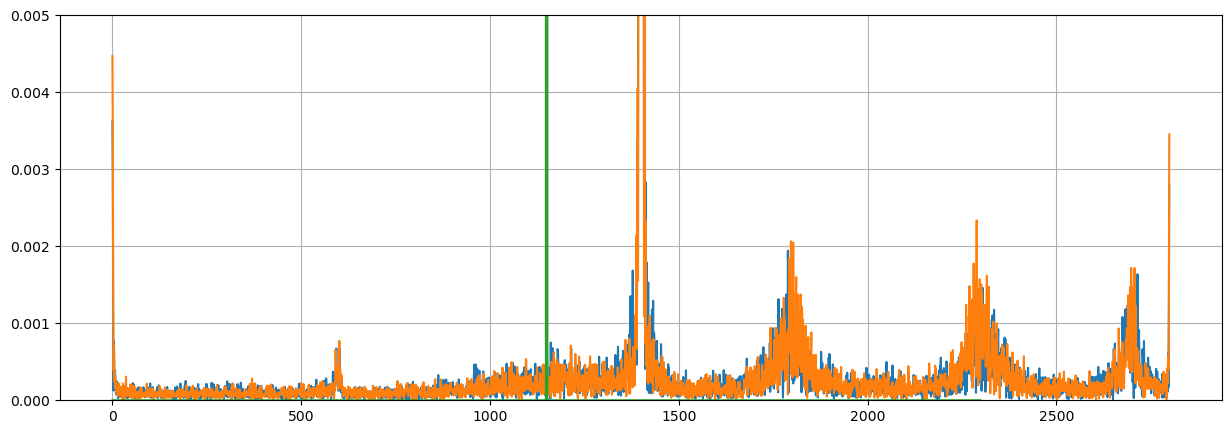

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
# data_ref = data_single_sweep[1]
ax.plot(np.abs(np.fft.fftshift(np.fft.fft(data_ref))))
ax.plot(np.abs(np.fft.fftshift(np.fft.fft(data_single_sweep[1]))))
Gauss_data = sin2(len(data_single_sweep[0])-500,0)*45-115
ax.plot(np.abs(np.fft.fftshift(np.fft.fft(Gauss_data-np.mean(Gauss_data)))))

ax.set_ylim(0,0.005)
ax.grid()

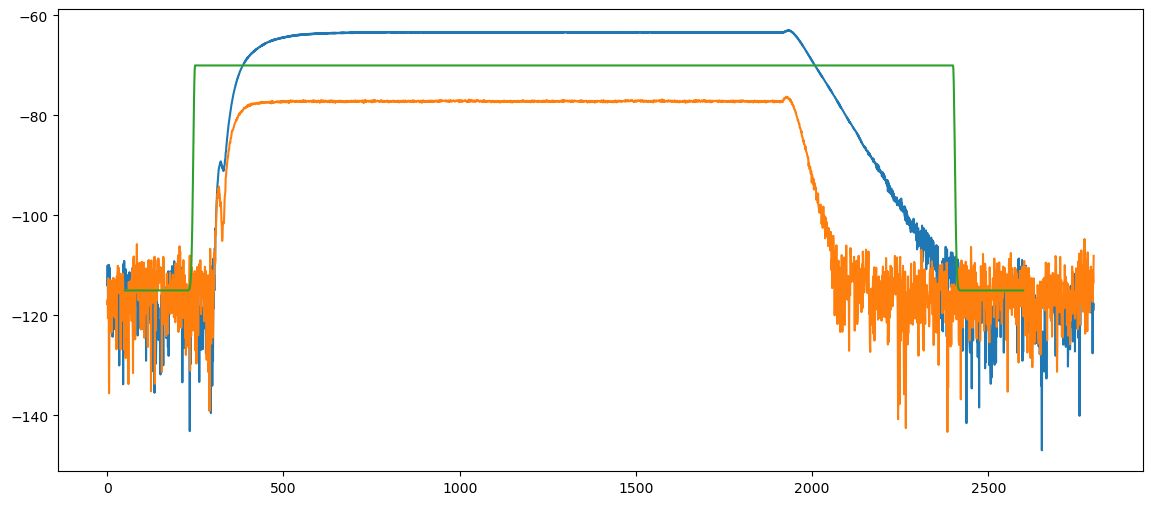

In [12]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(20*np.log10(np.abs(data[0])))
ax.plot(20*np.log10(np.abs(data[1])))
plt.plot(np.arange(len(data[1])-250)+50, Gauss(len(data[1])-250,0)*45-115)

In [13]:
print(datetime.now())

omega2 = 5.768314e9*2
lo_freq = (omega2 - 0.436e9)/2
if_freq  = omega2-lo_freq
Readout_freq = 5.768314e9
print(lo_freq)
print(if_freq)
print(Readout_freq)

delay = 100e-9
LO_duration=4600e-9
IF_duration=4000e-9
PR_duration = 4600e-9
Readout_duration = delay*4+PR_duration

experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'Pulse_test_pulse_duration',
        
        LO_freq=lo_freq,
        LO_amp=0.0/np.sqrt(2),
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = 0.0/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = 0.1,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=100e-6,
        readout_delay=200e-9,
        num_repeats=500, 
        num_averages=1000000,
        envelope_function = Gauss, 
    
    )

2024-11-27 18:19:58.145167
5550314000.0
5986314000.0
5768314000.0


In [14]:
print(datetime.now())
att_list = experiment.run(presto_address)
print(datetime.now())

data = att_list['data']
data.shape

2024-11-27 18:21:20.391622
Run finishedted at 2024-11-27 18:21:20.396138
2024-11-30 04:38:03.012981


(2000, 2, 5000)

In [15]:
TWPA1 = data[:,0,:]
TWPA2 = data[:,0,:]

TWPA1_db= 20*np.log10(np.abs(TWPA2))

TWPA1_db_cut = TWPA1_db

duration = np.arange(len(TWPA1_db_cut[0]))
itera = np.arange(len(TWPA1_db_cut))

TWPA1.shape

(2000, 5000)

In [45]:
data_mat = dict()
data_mat['TWPA_data'] = data
now = datetime.now()
file_name = '2000_sweeps_with_a_shunt'
full_file_name = file_folder + '\\' + file_name + now.strftime(r'--%Y.%m.%d_%H.%M.%S') + '.mat'
savemat(full_file_name, data_mat)

Text(0.5, 0, 'duration, ns')

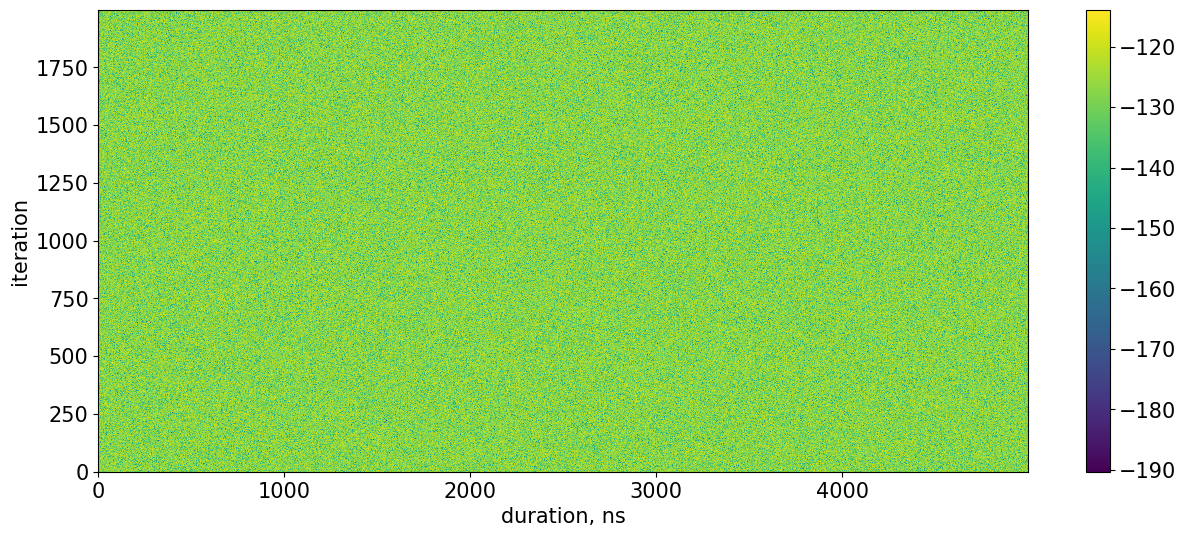

In [17]:
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(15,6))

TWPA1_db= 20*np.log10(np.abs(TWPA1))

TWPA1_db_cut = TWPA1_db

duration = np.arange(len(TWPA1_db_cut[0]))
itera = np.arange(len(TWPA1_db_cut))

c = ax.pcolor(duration, itera, TWPA1_db_cut, cmap = 'viridis')
fig.colorbar(c, ax=ax)
ax.set_ylabel('iteration')
ax.set_xlabel('duration, ns')

Text(0.5, 0, 'delay, ns')

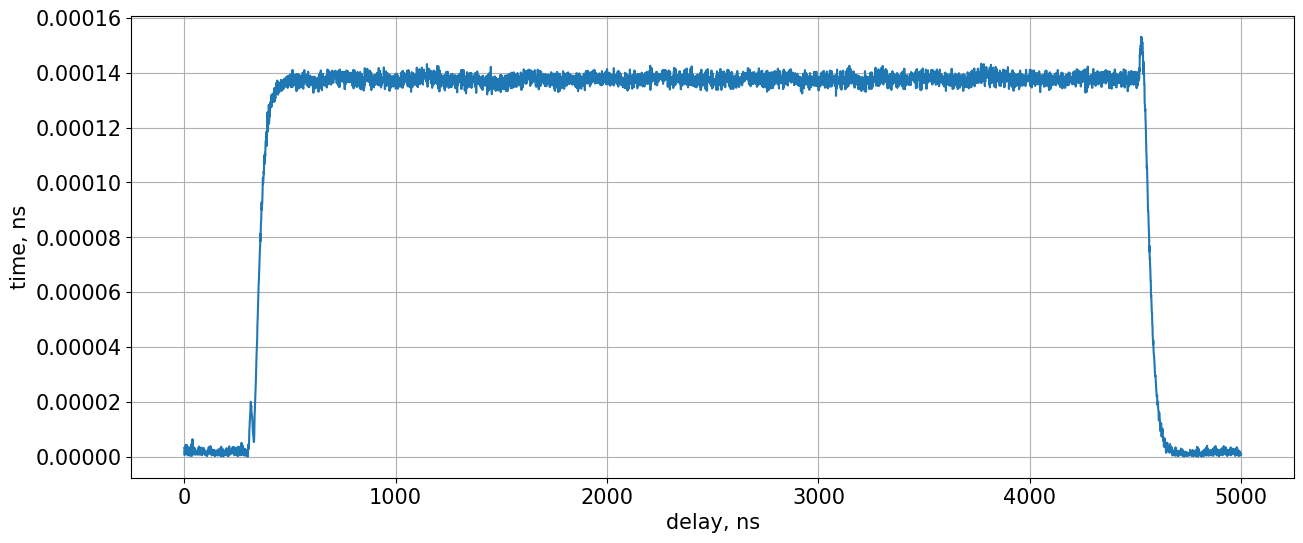

In [79]:
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(15,6))
c = ax.plot(np.abs(data[100,1,:]))
ax.grid()
ax.set_ylabel('time, ns')
ax.set_xlabel('delay, ns')

(0.0, 0.0001)

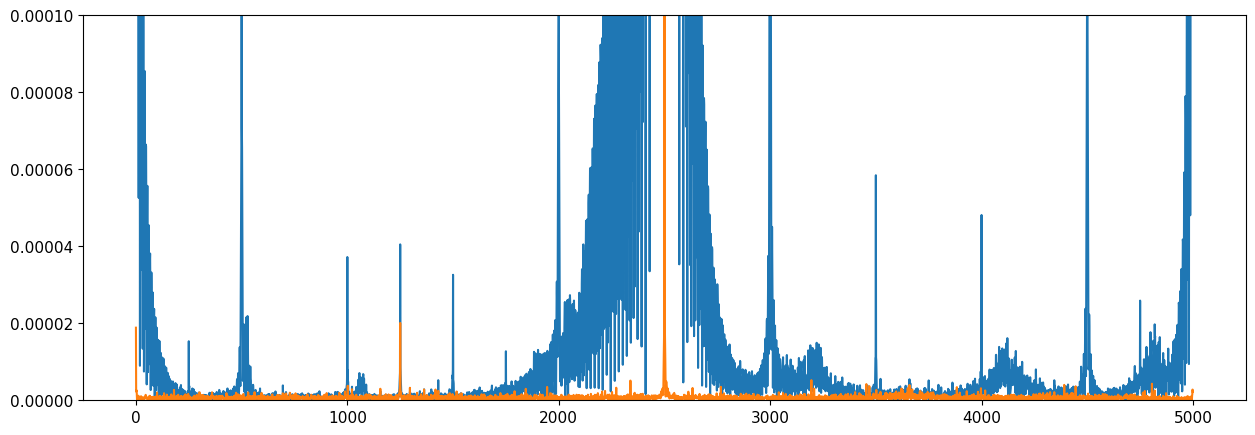

In [72]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.abs(np.fft.fftshift(np.fft.fft(np.mean(data[:,1,:], axis = 0)))))
ax.plot(np.abs(np.fft.fftshift(np.fft.fft(np.mean(data[:,0,:], axis = 0)))))

# ax.plot(np.abs(data[0,0,:]))
# ax.plot(np.abs(np.fft.fftshift(np.fft.fft(data[100,1,:]))))
ax.set_ylim(0,0.0001)

Text(0.5, 0, 'duration, ns')

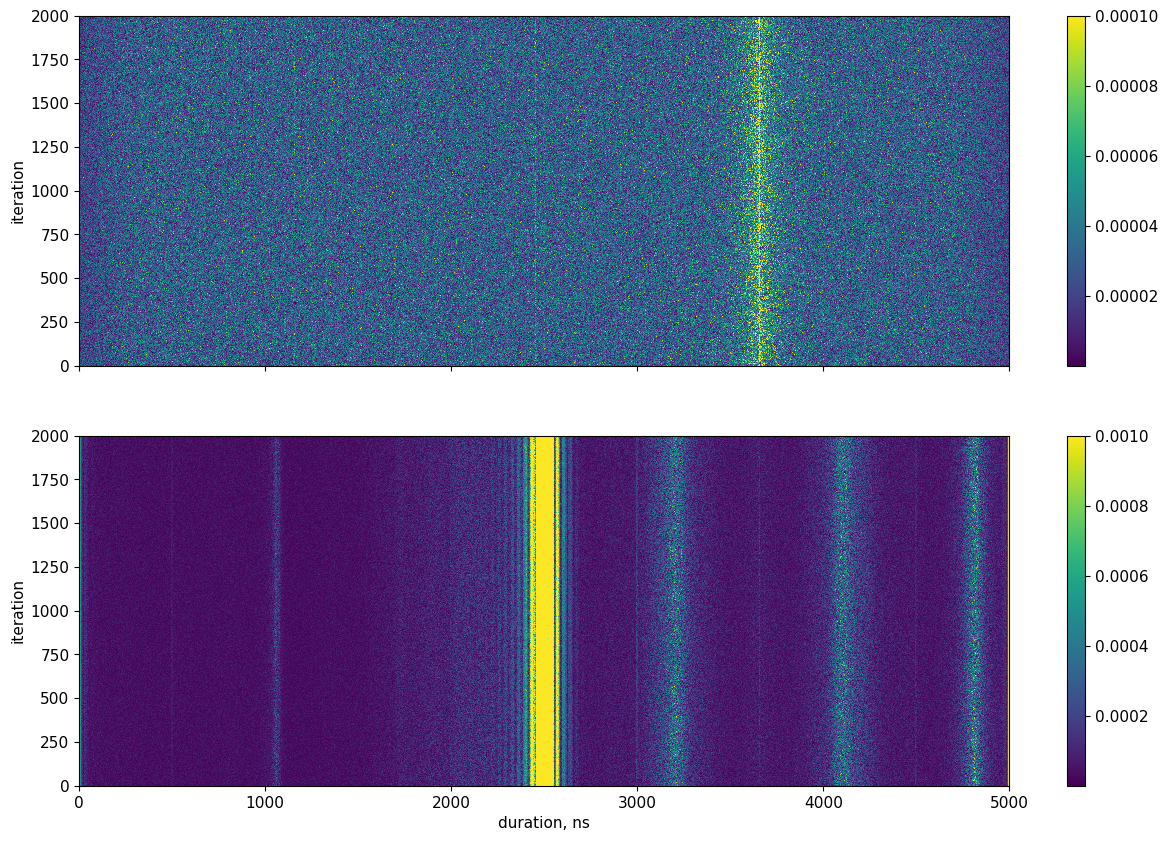

In [74]:
font = {'size'   : 11}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(2,1, figsize=(15,10), sharex = True)

TWPA1_db= 20*np.log10(np.abs(TWPA1))

TWPA1_db_cut = TWPA1_db

duration = np.arange(len(TWPA1_db_cut[0]))
itera = np.arange(len(TWPA1_db_cut))
fft_heatmap = np.abs(np.fft.fftshift(np.fft.fft(data[:,0,:])))

c = ax[0].pcolor(fft_heatmap, cmap = 'viridis', vmax=0.0001)
fig.colorbar(c, ax=ax[0]) 
ax[0].set_ylabel('iteration')

fft_heatmap = np.abs(np.fft.fftshift(np.fft.fft(data[:,1,:])))

c = ax[1].pcolor(fft_heatmap, cmap = 'viridis', vmax=0.001)
fig.colorbar(c, ax=ax[1])
ax[1].set_ylabel('iteration')
ax[1].set_xlabel('duration, ns')

In [48]:
if os.path.exists(file_folder) and os.path.isdir(file_folder):
    files = os.listdir(file_folder)
    for i in range(len(files)):
        if os.path.isfile(os.path.join(file_folder, files[i])):  # Check if it is a file
            print('[{}]-->'.format(i), files[i])

[0]--> 2000_sweeps_with_a_shunt--2024.12.02__12.49.29.mat
[1]--> 2000_sweeps_with_a_shunt--2024.12.02__14.07.44.mat
[2]--> 5000_sweeps--2024.11.27__16.08.48.mat


In [61]:
full_file_name = file_folder + '\\' + files[0]
data_mat = loadmat(full_file_name)
data_TWPA_old = data_mat['TWPA_data']

Text(0.5, 0, 'delay, ns')

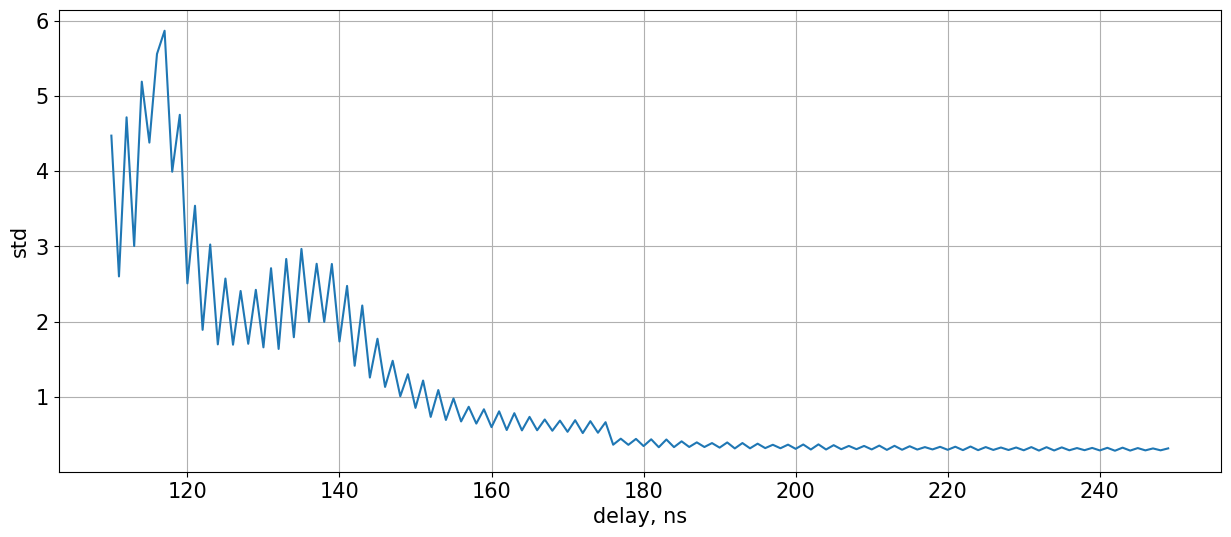

In [130]:
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(15,6))
c = ax.plot(duration[110:250], np.std(TWPA1_db.T, axis = 1)[110:250])
ax.grid()
ax.set_ylabel('std')
ax.set_xlabel('delay, ns')

# $$\textcolor{red}{\text{Covariance matrix reconstraction from pulses}}$$

$\textcolor{Purple}{\text{SETUP:}}$

Pulse is going to the pump line.

$\textcolor{Green}{\text{STATUS:}}$

1) Check if the phase is preserved between different measurements. After down-convertion a photon enters cavity and changes it elength.
It happens at any point, while the pulse is on, so, the outgoing signal will have a random phase shift. The question is if the shift is significant. 

$\textcolor{Orange}{\text{TODO:}}$

1) Pulse --> 4mus meas --> 16 mus delay

2) Check Presto measurement bandwidth in pulsed case (1MHz???)


In [40]:
print(datetime.now())

omega2 = 6.036714e9*2
lo_freq = (omega2 - 0.436e9)/2
if_freq  = omega2-lo_freq
Readout_freq = omega2/2
print(lo_freq)
print(if_freq)
print(Readout_freq)

Readout_phase = np.pi
Downsampling = 1

delay = 200e-9
LO_duration=400e-9
IF_duration= 50e-9
PR_duration = 800e-9

# delay = 200e-9
# LO_duration=22000e-9
# IF_duration= 21000e-9
# PR_duration = 24000e-9

readout_delay = 200e-9
wait_delay = 5e-6
Readout_duration = delay*2+PR_duration

LO_amp = 0.00
IF_amp = 0.00
PR_amp = 1

num_repeats = 1
num_averages = 10

experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'Covariance_of_pulses_with_different_length',
        
        LO_freq=lo_freq,
        LO_amp=LO_amp/2,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = IF_amp/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = PR_amp,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        readout_phase=Readout_phase,
        downsampling=Downsampling,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=wait_delay,
        readout_delay=readout_delay,
        num_repeats=num_repeats, 
        num_averages=num_averages,
        # envelope_function = sin2, 
    
    )

2025-01-17 08:55:13.247388
5818714000.0
6254714000.0
6036714000.0


In [41]:
timestart = datetime.now()
# print(timestart)

att_list = experiment.run(presto_address)
data = att_list['data']
TWPA1 = data[:,0,:]
TWPA2 = data[:,1,:]

timestop = datetime.now()
# print(timestop)
print(timestop-timestart)

# sio.savemat(str(file_folder) + '\\Probe.mat', {'TWPA1': TWPA1, 'omega2': omega2, 'lo_freq': lo_freq,
#              'if_freq': if_freq, 'Readout_freq': Readout_freq, 'delay': delay, 'LO_duration': LO_duration,
#              'IF_duration': IF_duration, 'PR_duration': PR_duration, 'readout_delay': readout_delay,
#              'Readout_duration': Readout_duration, 'avgs': avgs, 'wait_delay': wait_delay, 'LO_amp': LO_amp,
#              'IF_amp': IF_amp, 'num_repeats': num_repeats, 'num_averages': num_averages, 'PR_amp': PR_amp})

TWPA1.shape

Run finishedted at 2025-01-17 08:55:14.132685
0:00:00.575246


(1, 1200)

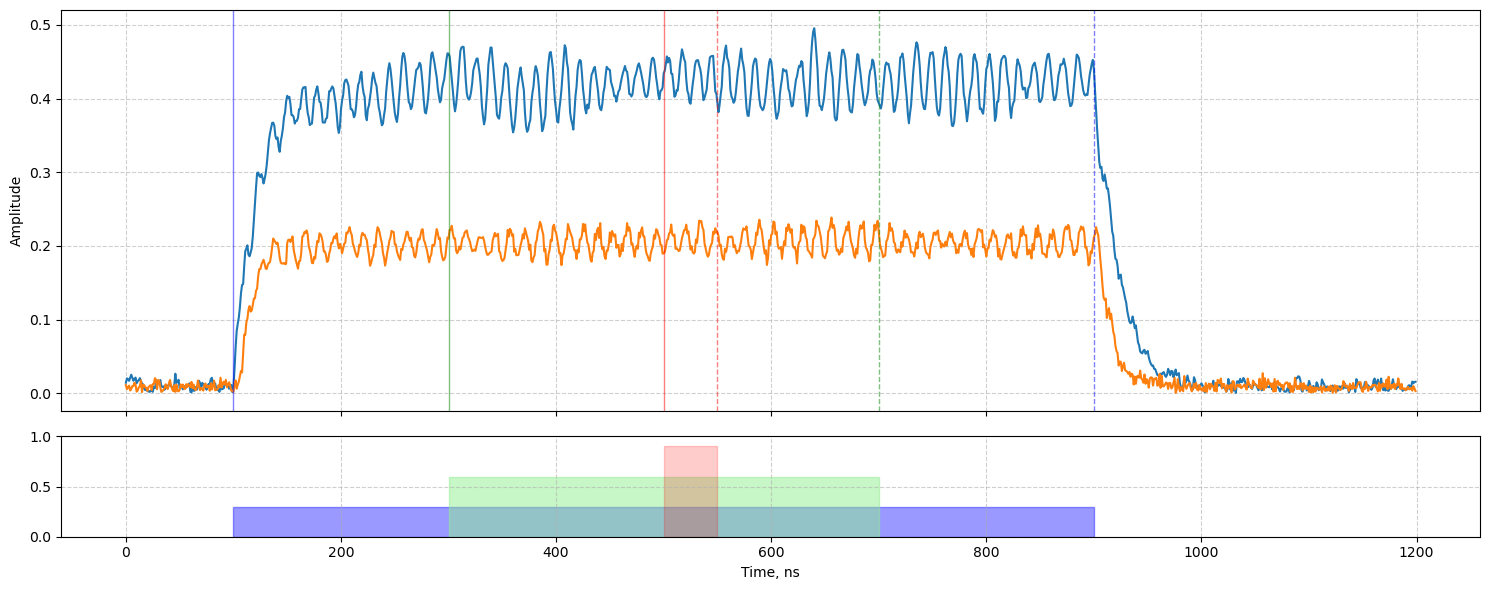

In [42]:
import matplotlib.patches as patches
fig = plt.figure(figsize=(15, 6))
grid = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[4, 1])
ax = fig.add_subplot(grid[0, 0])
# c = ax.plot(np.unwrap(np.angle(TWPA1[0, :])))
# c = ax.plot(np.angle(TWPA1[0, :]))
c = ax.plot(np.abs(TWPA1[0, :]))
c = ax.plot(np.abs(TWPA2[0, :]))
# c = ax.plot(np.abs(Data))


start = 100
ax.axvline(x=start, color='blue', linestyle='-', linewidth=1, alpha = 0.5,  label='Probe start')
ax.axvline(x=start+(PR_duration)*1e9, color='blue', linestyle='--', linewidth=1, alpha = 0.5,  label='Probe start')

ax.axvline(x=start+delay*1e9, color='green', linestyle='-', linewidth=1, alpha = 0.5,  label='LO start')
ax.axvline(x=start+delay*1e9+(LO_duration)*1e9, color='green', linestyle='--', linewidth=1, alpha = 0.5,  label='LO start')


ax.axvline(x=start+2*delay*1e9, color='red', linestyle='-', linewidth=1, alpha = 0.5,  label='Pulse start')
ax.axvline(x=start+2*delay*1e9+(IF_duration)*1e9, color='red', linestyle='--', linewidth=1, alpha = 0.5,  label='Pulse end')

ax.set_ylabel("Amplitude")
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid with specific styling
# ax.set_ylim(-0.5,0.4)
# ax.set_xlim(1400,2800)


ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
rectangle = patches.Rectangle((start, 0), width=(PR_duration)*1e9, height=0.3, color='blue', alpha=0.4)
ax2.add_patch(rectangle)

rectangle = patches.Rectangle((start+delay*1e9, 0), width=(LO_duration)*1e9, height=0.6, color='lightgreen', alpha=0.5)
ax2.add_patch(rectangle)

rectangle = patches.Rectangle((start+2*delay*1e9, 0), width=(IF_duration)*1e9, height=0.9, color='red', alpha=0.2)
ax2.add_patch(rectangle)


ax2.set_xlabel("Time, ns")
ax2.grid(True, linestyle='--', alpha=0.6)  # Add a grid with the same styling

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

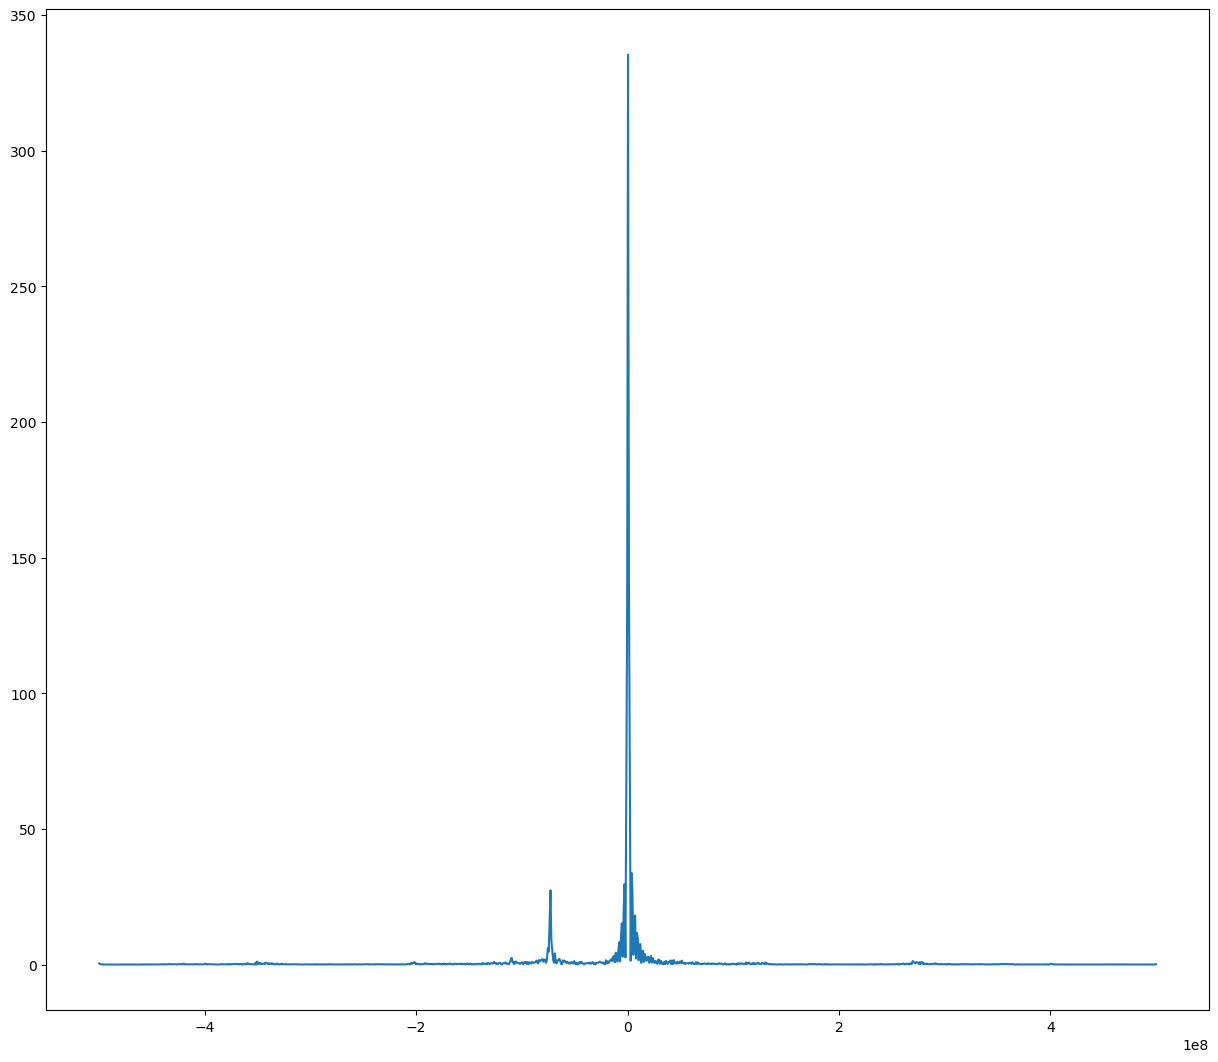

In [43]:
Filter = 0
FFT0 = np.fft.fft(data[0,0,:])
FFT0[int(np.round(len(FFT0))/2)-Filter:int(np.round(len(FFT0))/2)+Filter] = 0
data[0,0,:] = np.fft.ifft(FFT0)
x=np.linspace(-500e6, 500e6, num=len(FFT0))
fig, ax = plt.subplots(figsize=(15,13))
ax.plot(x,np.abs(np.fft.fftshift(np.fft.fft(data[0,0,:]))))

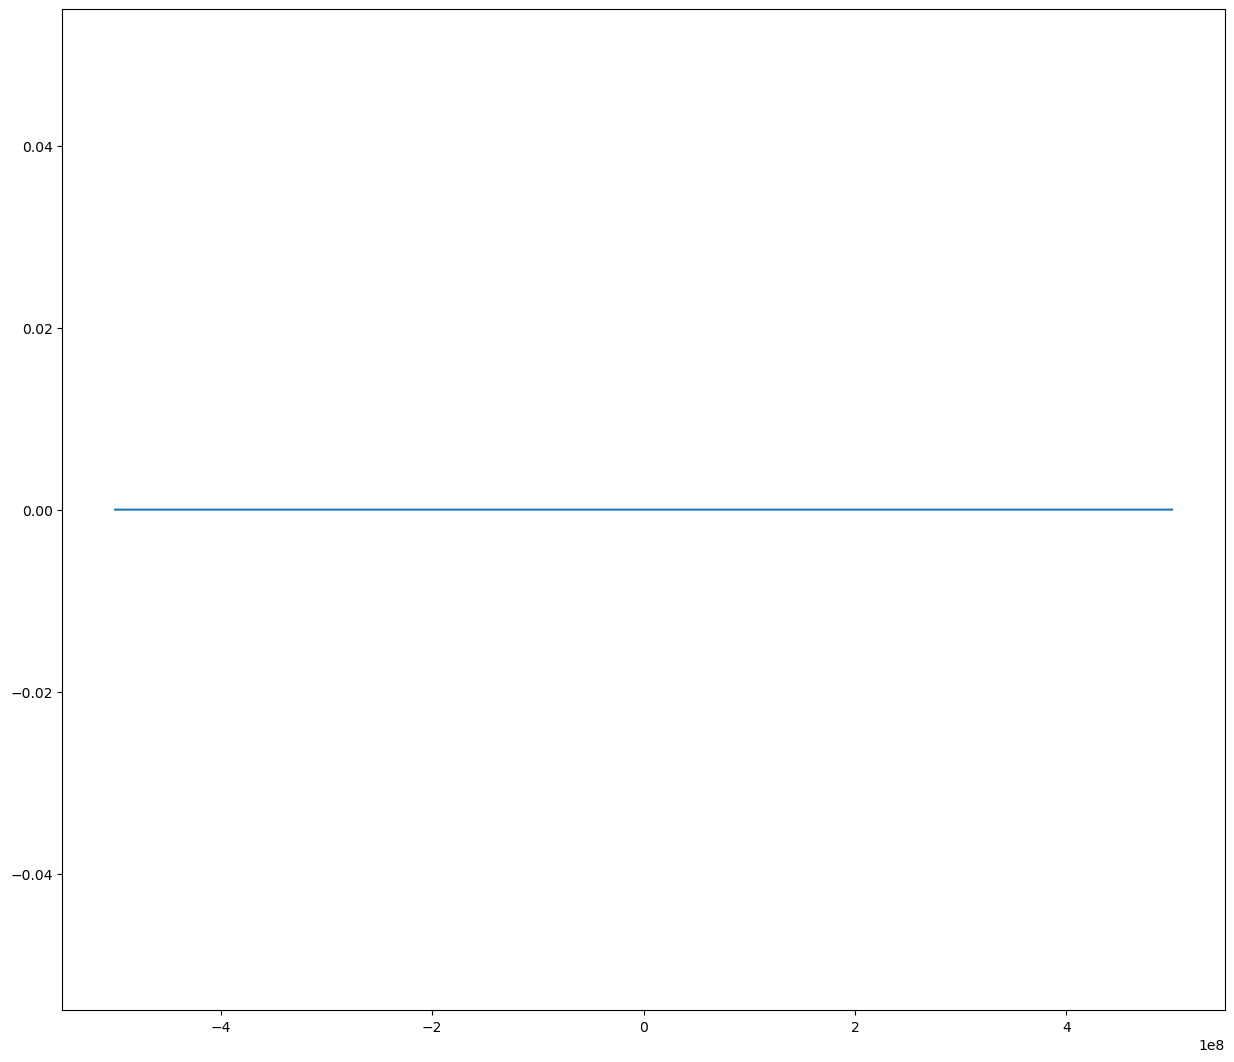

In [117]:
Filter = 0
FFT0 = np.fft.fft(Data)
FFT0[int(np.round(len(FFT0))/2)-Filter:int(np.round(len(FFT0))/2)+Filter] = 0
Data = np.fft.ifft(FFT0)
x=np.linspace(-500e6/SumInt, 500e6/SumInt, num=len(Data))
fig, ax = plt.subplots(figsize=(15,13))
ax.plot(x,np.abs(np.fft.fftshift(np.fft.fft(Data))))

In [ ]:
avgs = 500

timestart = datetime.now()
# print(timestart)

for i in range(avgs):

    experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'CW-comparison pump off short',
        
        LO_freq=lo_freq,
        LO_amp=LO_amp/2,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = 0.00/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = PR_amp,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        readout_phase=Readout_phase
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=wait_delay,
        readout_delay=readout_delay,
        num_repeats=num_repeats, 
        num_averages=num_averages,
        # envelope_function = sin2, 
    )
    
    att_list = experiment.run(presto_address)
    data = att_list['data']
    TWPA1 = data[:,0,:]
    # TWPA2 = data[:,1,:]

    sio.savemat(str(file_folder) + '\\off' + str(i) + '.mat', {'TWPA1': TWPA1, 'omega2': omega2, 'lo_freq': lo_freq,
             'if_freq': if_freq, 'Readout_freq': Readout_freq, 'delay': delay, 'LO_duration': LO_duration,
             'IF_duration': IF_duration, 'PR_duration': PR_duration, 'readout_delay': readout_delay,
             'Readout_duration': Readout_duration, 'avgs': avgs, 'wait_delay': wait_delay, 'LO_amp': LO_amp,
             'IF_amp': IF_amp, 'num_repeats': num_repeats, 'num_averages': num_averages, 'PR_amp': PR_amp})

    experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'CW-comparison pump on short',
        
        LO_freq=lo_freq,
        LO_amp=LO_amp/2,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = 0.02/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = PR_amp,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        readout_phase=Readout_phase,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=wait_delay,
        readout_delay=readout_delay,
        num_repeats=num_repeats, 
        num_averages=num_averages,
        # envelope_function = sin2, 
    )

    att_list = experiment.run(presto_address)
    data = att_list['data']
    TWPA1 = data[:,0,:]
    # TWPA2 = data[:,1,:]

    sio.savemat(str(file_folder) + '\\on' + str(i) + '.mat', {'TWPA1': TWPA1, 'omega2': omega2, 'lo_freq': lo_freq,
             'if_freq': if_freq, 'Readout_freq': Readout_freq, 'delay': delay, 'LO_duration': LO_duration,
             'IF_duration': IF_duration, 'PR_duration': PR_duration, 'readout_delay': readout_delay,
             'Readout_duration': Readout_duration, 'avgs': avgs, 'wait_delay': wait_delay, 'LO_amp': LO_amp,
             'IF_amp': IF_amp, 'num_repeats': num_repeats, 'num_averages': num_averages, 'PR_amp': PR_amp})

timestop = datetime.now()
# print(timestop)
print(timestop-timestart)

# TWPA1.shape

In [ ]:
TWPA = data[0,0,:]
SumInt = 2
N = int(np.round(len(TWPA)/SumInt))
Data = np.zeros(N,dtype=np.complex_)
for i in range(N):
    Data[i] = np.sum(TWPA[0+i*SumInt:SumInt+i*SumInt])/SumInt

# Sweep over pulse duration

In [27]:
print(datetime.now())

omega2 = 5.768314e9*2
lo_freq = (omega2 - 0.436e9)/2
if_freq  = omega2-lo_freq
Readout_freq = 5.768314e9
Readout_phase = 0
print(lo_freq)
print(if_freq)
print(Readout_freq)

delay = 700e-9
LO_duration=4000e-9
IF_duration= 20e-9
PR_duration = 5000e-9
readout_delay = 200e-9
Readout_duration = delay*2+PR_duration

experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'Covariance_of_pulses_with_different_length',
        save_= True,
        
        LO_freq=lo_freq,
        LO_amp=0.1,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = 0.1,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = 0.1,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        readout_phase=Readout_phase,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=50e-6,
        readout_delay=readout_delay,
        num_repeats=1, 
        num_averages=1,
        envelope_function = sin2, 
    
    )

2024-12-03 12:43:11.532890
5550314000.0
5986314000.0
5768314000.0


In [28]:
pulse_duration = np.arange(2, 1000, 10)
repeats = 10000
TWPA1 = np.empty((len(pulse_duration), repeats, 6400))

experiment.num_repeats = repeats
for i in range(len(pulse_duration)): 
    experiment.IF_duration = pulse_duration[i]
    
    print('Duration = ', pulse_duration[i])
    att_list = experiment.run(presto_address)
    
    data = att_list['data']
    TWPA1[i] = TWPA1[i,:,:]

TWPA1.shape

Duration =  2
Data is saved to  F:\ColdMeasurements\NanoY\Data\Pulsed_measurements_T1_corr\Covariance_of_pulses_with_different_length--2024.12.03__12.43.35.mat
Duration =  12
Data is saved to  F:\ColdMeasurements\NanoY\Data\Pulsed_measurements_T1_corr\Covariance_of_pulses_with_different_length--2024.12.03__12.43.56.mat
Duration =  22
Data is saved to  F:\ColdMeasurements\NanoY\Data\Pulsed_measurements_T1_corr\Covariance_of_pulses_with_different_length--2024.12.03__12.44.19.mat
Duration =  32
Data is saved to  F:\ColdMeasurements\NanoY\Data\Pulsed_measurements_T1_corr\Covariance_of_pulses_with_different_length--2024.12.03__12.44.40.mat
Duration =  42
Data is saved to  F:\ColdMeasurements\NanoY\Data\Pulsed_measurements_T1_corr\Covariance_of_pulses_with_different_length--2024.12.03__12.45.18.mat
Duration =  52
Data is saved to  F:\ColdMeasurements\NanoY\Data\Pulsed_measurements_T1_corr\Covariance_of_pulses_with_different_length--2024.12.03__12.45.57.mat
Duration =  62
Data is saved to  F:

OSError: [Errno 28] No space left on device

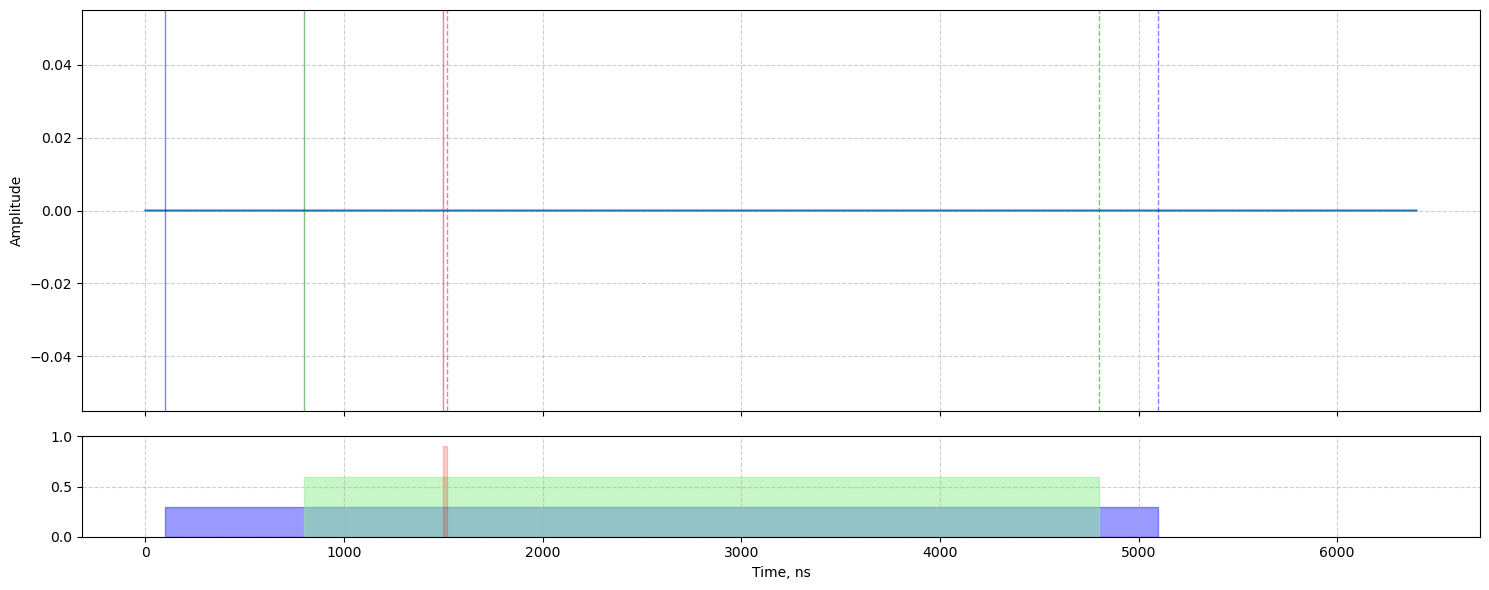

In [37]:
fig = plt.figure(figsize=(15, 6))
grid = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[4, 1])
ax = fig.add_subplot(grid[0, 0])
# c = ax.plot(np.unwrap(np.angle(TWPA1[0, :])))

TWPA1_m = TWPA1[10, 1, :]
c = ax.plot(np.angle(TWPA1_m))
# c = ax.plot(np.abs(TWPA1[0, :]))

start = 100
ax.axvline(x=start, color='blue', linestyle='-', linewidth=1, alpha = 0.5,  label='Probe start')
ax.axvline(x=start+(PR_duration)*1e9, color='blue', linestyle='--', linewidth=1, alpha = 0.5,  label='Probe start')
ax.axvline(x=start+delay*1e9, color='green', linestyle='-', linewidth=1, alpha = 0.5,  label='LO start')
ax.axvline(x=start+delay*1e9+(LO_duration)*1e9, color='green', linestyle='--', linewidth=1, alpha = 0.5,  label='LO start')
ax.axvline(x=start+2*delay*1e9, color='red', linestyle='-', linewidth=1, alpha = 0.5,  label='Pulse start')
ax.axvline(x=start+2*delay*1e9+(IF_duration)*1e9, color='red', linestyle='--', linewidth=1, alpha = 0.5,  label='Pulse end')
ax.set_ylabel("Amplitude")
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid with specific styling
# ax.set_ylim(-0.25,0.25)
ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
rectangle = patches.Rectangle((start, 0), width=(PR_duration)*1e9, height=0.3, color='blue', alpha=0.4)
ax2.add_patch(rectangle)
rectangle = patches.Rectangle((start+delay*1e9, 0), width=(LO_duration)*1e9, height=0.6, color='lightgreen', alpha=0.5)
ax2.add_patch(rectangle)
rectangle = patches.Rectangle((start+2*delay*1e9, 0), width=(IF_duration)*1e9, height=0.9, color='red', alpha=0.2)
ax2.add_patch(rectangle)
ax2.set_xlabel("Time, ns")
ax2.grid(True, linestyle='--', alpha=0.6)  # Add a grid with the same styling
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

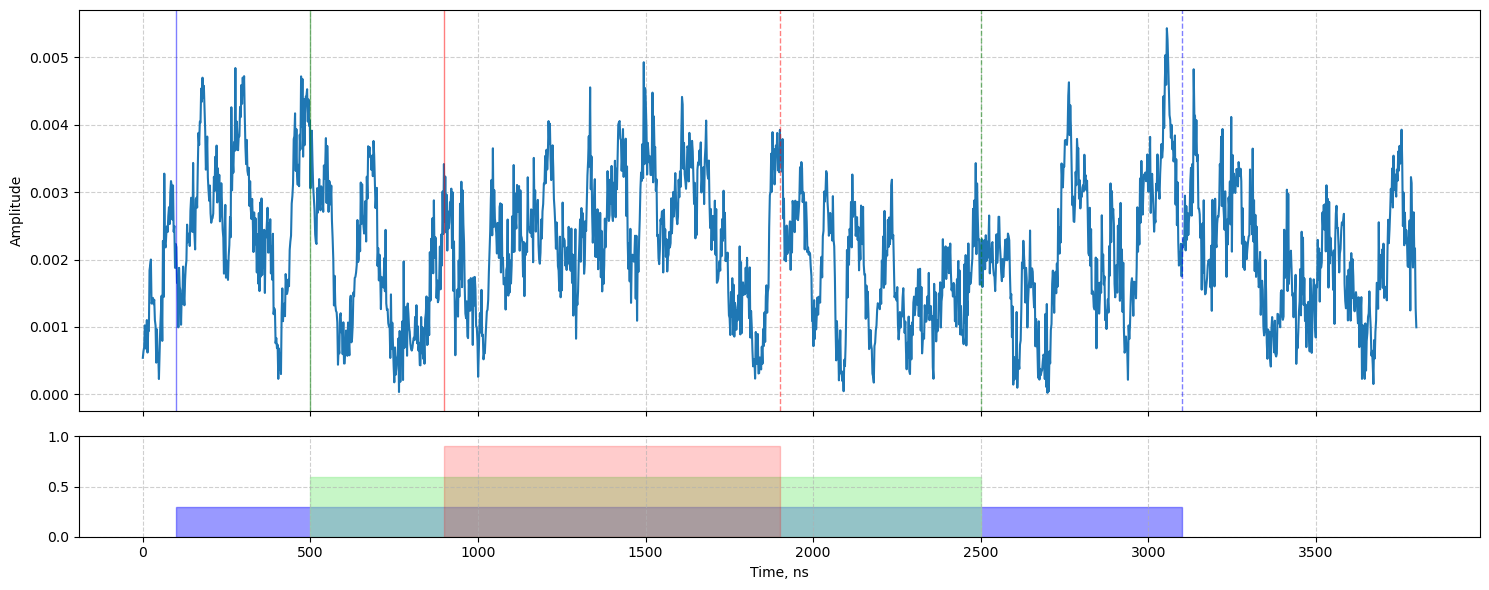

In [135]:
import matplotlib.patches as patches
fig = plt.figure(figsize=(15, 6))
grid = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[4, 1])
ax = fig.add_subplot(grid[0, 0])
# c = ax.plot(np.unwrap(np.angle(TWPA1[0, :])))
# c = ax.plot(np.angle(TWPA1[0, :]))
# c = ax.plot(np.real(TWPA1[0, :]))
time = np.linspace(0,SumInt*len(Data),len(Data))
c = ax.plot(time,np.abs(Data))


start = 100
ax.axvline(x=start, color='blue', linestyle='-', linewidth=1, alpha = 0.5,  label='Probe start')
ax.axvline(x=start+(PR_duration)*1e9, color='blue', linestyle='--', linewidth=1, alpha = 0.5,  label='Probe start')

ax.axvline(x=start+delay*1e9, color='green', linestyle='-', linewidth=1, alpha = 0.5,  label='LO start')
ax.axvline(x=start+delay*1e9+(LO_duration)*1e9, color='green', linestyle='--', linewidth=1, alpha = 0.5,  label='LO start')


ax.axvline(x=start+2*delay*1e9, color='red', linestyle='-', linewidth=1, alpha = 0.5,  label='Pulse start')
ax.axvline(x=start+2*delay*1e9+(IF_duration)*1e9, color='red', linestyle='--', linewidth=1, alpha = 0.5,  label='Pulse end')

ax.set_ylabel("Amplitude")
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid with specific styling
# ax.set_ylim(-0.5,0.4)
# ax.set_xlim(1400,2800)


ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
rectangle = patches.Rectangle((start, 0), width=(PR_duration)*1e9, height=0.3, color='blue', alpha=0.4)
ax2.add_patch(rectangle)

rectangle = patches.Rectangle((start+delay*1e9, 0), width=(LO_duration)*1e9, height=0.6, color='lightgreen', alpha=0.5)
ax2.add_patch(rectangle)

rectangle = patches.Rectangle((start+2*delay*1e9, 0), width=(IF_duration)*1e9, height=0.9, color='red', alpha=0.2)
ax2.add_patch(rectangle)


ax2.set_xlabel("Time, ns")
ax2.grid(True, linestyle='--', alpha=0.6)  # Add a grid with the same styling

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

# Test Coupler

In [207]:
print(datetime.now())

omega2 = 5.768314e9*2
lo_freq = (omega2 - 0.436e9)/2
if_freq  = omega2-lo_freq
Readout_freq = 5.768314e9
Readout_phase = 0
print(lo_freq)
print(if_freq)
print(Readout_freq)

delay = 200e-9
LO_duration=400e-9
IF_duration= 50e-9
PR_duration = 800e-9

# delay = 200e-9
# LO_duration=22000e-9
# IF_duration= 21000e-9
# PR_duration = 24000e-9

readout_delay = 200e-9
wait_delay = 5e-6
Readout_duration = delay*2+PR_duration

LO_amp = 0.0
IF_amp = 0.0
PR_amp = 1

num_repeats = 1
num_averages = 1000000

experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=5,  # TWPA 2
        readout_port2=6,  # TWPA 1
        file_folder = file_folder,
        file_name = 'Covariance_of_pulses_with_different_length',
        
        LO_freq=lo_freq,
        LO_amp=LO_amp/2,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = IF_amp/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = Readout_freq,
        PR_amp = PR_amp,
        PR_duration = PR_duration, 

        readout_freq=Readout_freq,
        readout_phase=Readout_phase,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=wait_delay,
        readout_delay=readout_delay,
        num_repeats=num_repeats, 
        num_averages=num_averages,
        # envelope_function = sin2, 
    
    )

2024-12-19 18:32:50.800222
5550314000.0
5986314000.0
5768314000.0


In [210]:
timestart = datetime.now()
# print(timestart)

att_list = experiment.run(presto_address)
data = att_list['data']
TWPA1 = data[:,0,:]
TWPA2 = data[:,1,:]

timestop = datetime.now()
# print(timestop)
print(timestop-timestart)

TWPA1.shape

Run finishedted at 2024-12-19 18:45:37.828152
0:00:06.583123


(1, 1200)

In [211]:
# %matplotlib qt
import matplotlib.patches as patches

start = 0

fig = plt.figure(figsize=(8, 6))
grid = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[4, 4, 1])
ax = fig.add_subplot(grid[0, 0])
c = ax.plot(np.abs(TWPA1[0, :]))
c = ax.plot(np.abs(TWPA2[0, :]))
ax.axvline(x=start, color='blue', linestyle='-', linewidth=1, alpha = 0.5,  label='Probe start')
ax.axvline(x=start+(PR_duration)*1e9, color='blue', linestyle='--', linewidth=1, alpha = 0.5,  label='Probe start')

ax.set_ylabel("Amplitude")
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid with specific styling
# ax.set_ylim(-0.5,0.4)
# ax.set_xlim(1400,2800)


ax1 = fig.add_subplot(grid[1, 0])
c = ax1.plot(np.angle(TWPA1[0, :])*180/np.pi)
c = ax1.plot(np.angle(TWPA2[0, :])*180/np.pi)
ax1.axvline(x=start, color='blue', linestyle='-', linewidth=1, alpha = 0.5,  label='Probe start')
ax1.axvline(x=start+(PR_duration)*1e9, color='blue', linestyle='--', linewidth=1, alpha = 0.5,  label='Probe start')

ax1.set_ylabel("Phase")
ax1.grid(True, linestyle='--', alpha=0.6)  # Add a grid with specific styling


ax2 = fig.add_subplot(grid[2, 0], sharex=ax)
rectangle = patches.Rectangle((start, 0), width=(PR_duration)*1e9, height=0.3, color='blue', alpha=0.4)
ax2.add_patch(rectangle)

ax2.set_xlabel("Time, ns")
ax2.grid(True, linestyle='--', alpha=0.6)  # Add a grid with the same styling

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

In [178]:
Global_data_adress = r"D:\Data\NanoY"
exp_name = 'CouplerRoomTempTest'
file_folder = Global_data_adress+'\\'+exp_name


sio.savemat(str(file_folder) + '\\Probe.mat', {'TWPA1': TWPA1, 'TWPA2': TWPA2, 'omega2': omega2, 'lo_freq': lo_freq,
             'if_freq': if_freq, 'Readout_freq': Readout_freq, 'delay': delay, 'LO_duration': LO_duration,
             'IF_duration': IF_duration, 'PR_duration': PR_duration, 'readout_delay': readout_delay,
             'Readout_duration': Readout_duration, 'avgs': avgs, 'wait_delay': wait_delay, 'LO_amp': LO_amp,
             'IF_amp': IF_amp, 'num_repeats': num_repeats, 'num_averages': num_averages, 'PR_amp': PR_amp})

In [190]:
Global_data_adress = r"D:\Data\NanoY"
exp_name = 'CouplerRoomTempTest'
file_folder = Global_data_adress+'\\'+exp_name

frequencies = np.linspace(5e9,6e9,101,endpoint=True)
nr_frequencies = len(frequencies)
Readout_phase = 0

timestart = datetime.now()
# print(timestart)

TWPA1 = np.zeros([nr_frequencies,1200],dtype=complex)
TWPA2 = np.zeros([nr_frequencies,1200],dtype=complex)

for i in range(nr_frequencies):

    experiment = ptpr.T1(
        LO_port=3, # LO
        IF_port=1, # IF
        PR_port=8,  # Probe
        readout_port1=7,  # TWPA 2
        readout_port2=8,  # TWPA 1
        file_folder = file_folder,
        file_name = 'CouplerFrequencySweep',
        
        LO_freq=lo_freq,
        LO_amp=0/2,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = 0/2,
        IF_duration=IF_duration,             # pulse duration

        PR_freq = frequencies[i],
        PR_amp = PR_amp,
        PR_duration = PR_duration, 

        readout_freq=frequencies[i],
        readout_phase=Readout_phase,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=wait_delay,
        readout_delay=readout_delay,
        num_repeats=num_repeats, 
        num_averages=num_averages,
        # envelope_function = sin2, 
    )
    
    att_list = experiment.run(presto_address)
    data = att_list['data']
    TWPA1[i,:] = data[0,0,:]
    TWPA2[i,:] = data[0,1,:]

    sio.savemat(str(file_folder) + '\\FreSweep.mat', {'TWPA1': TWPA1, 'omega2': omega2, 'lo_freq': lo_freq,
             'if_freq': if_freq, 'Readout_freq': Readout_freq, 'delay': delay, 'LO_duration': LO_duration,
             'IF_duration': IF_duration, 'PR_duration': PR_duration, 'readout_delay': readout_delay,
             'Readout_duration': Readout_duration, 'avgs': avgs, 'wait_delay': wait_delay, 'LO_amp': LO_amp,
             'IF_amp': IF_amp, 'num_repeats': num_repeats, 'num_averages': num_averages, 'PR_amp': PR_amp})

timestop = datetime.now()
# print(timestop)
print(timestop-timestart)

# TWPA1.shape

Run finishedted at 2024-12-19 15:48:38.313078
Run finishedted at 2024-12-19 15:48:44.907065
Run finishedted at 2024-12-19 15:48:51.491611
Run finishedted at 2024-12-19 15:48:58.065374
Run finishedted at 2024-12-19 15:49:04.649379
Run finishedted at 2024-12-19 15:49:11.237822
Run finishedted at 2024-12-19 15:49:17.822922
Run finishedted at 2024-12-19 15:49:24.410825
Run finishedted at 2024-12-19 15:49:30.997392
Run finishedted at 2024-12-19 15:49:37.580873
Run finishedted at 2024-12-19 15:49:44.166790
Run finishedted at 2024-12-19 15:49:50.750809
Run finishedted at 2024-12-19 15:49:57.334760
Run finishedted at 2024-12-19 15:50:03.912634
Run finishedted at 2024-12-19 15:50:10.494851
Run finishedted at 2024-12-19 15:50:17.085299
Run finishedted at 2024-12-19 15:50:23.675610
Run finishedted at 2024-12-19 15:50:30.267728
Run finishedted at 2024-12-19 15:50:36.850636
Run finishedted at 2024-12-19 15:50:43.438298
Run finishedted at 2024-12-19 15:50:50.026036
Run finishedted at 2024-12-19 15:5